In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
from skimage import data_dir
from skimage.transform import resize
import time

In [ ]:
noise_var = np.logspace(0, 2, 5)
data_dir = '/content/drive/MyDrive/TEST'
lena = io.ImageCollection(data_dir + "/lena.png")[0].astype(np.float) / 255.0

lena = resize(lena, (lena.shape[0]/2, lena.shape[1]/2, lena.shape[2] - 1))

lena = color.rgb2lab(lena)

lena = lena[:,:,0]

noisy = []
for sigma2 in noise_var:
    noise = np.random.normal(0, np.sqrt(sigma2), lena.shape)
  
    n = lena + noise
    # avoid going over bounds
    n[n > 100] = 100
    n[n < 0] = 0
    noisy.append(n)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def PSNR(original, noisy, peak=100):
    mse = np.mean((original-noisy)**2)
    return 10*np.log10(peak*peak/mse)

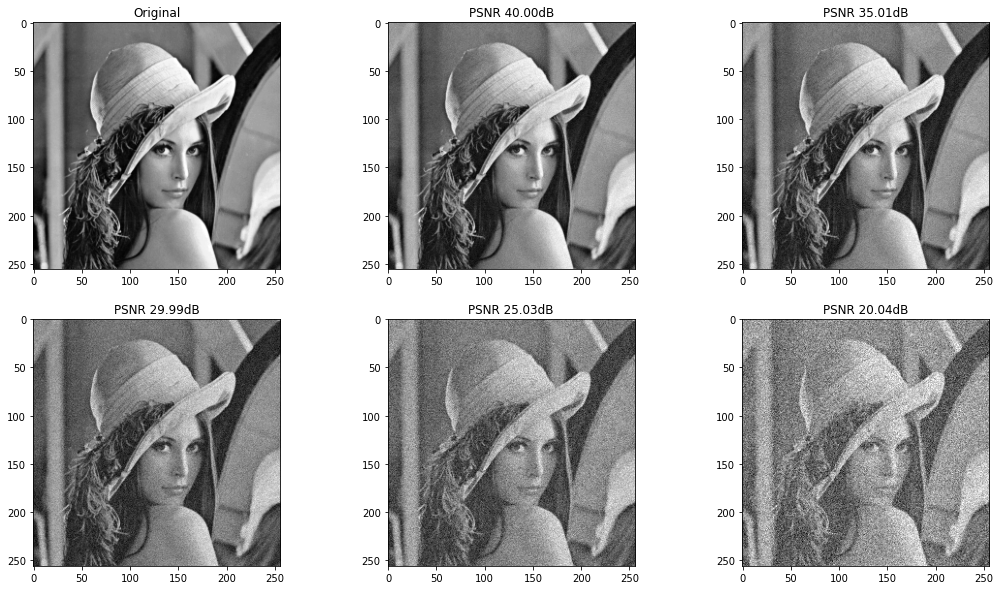

In [ ]:
plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
plt.imshow(lena,cmap='gray')
plt.title("Original")
for i,n in enumerate(noisy):
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.2f}dB".format(PSNR(lena, n)))
    plt.imshow(n,cmap='gray')

In [ ]:
def estimate_noise(img):
    upper = img[:-2, 1:-1].flatten()
    lower = img[2:, 1:-1].flatten()
    left = img[1:-1, :-2].flatten()
    right = img[1:-1, 2:].flatten()
    central = img[1:-1, 1:-1].flatten()
    U = np.column_stack((upper, lower, left, right))
    c_estimated = np.dot(U, np.dot(np.linalg.pinv(U), central))
    error = np.mean((central - c_estimated)**2)
    sigma = np.sqrt(error)
    return sigma

In [ ]:
sigmas = []
for i,n in enumerate(noisy):
    sigma = estimate_noise(n)
    sigmas.append(sigma)
    print("Estimated noise is {0:.4f}, real noise is {1:.4f}".format(sigma, np.sqrt(noise_var[i])))
    

Estimated noise is 2.0734, real noise is 1.0000
Estimated noise is 2.6649, real noise is 1.7783
Estimated noise is 3.9719, real noise is 3.1623
Estimated noise is 6.5469, real noise is 5.6234
Estimated noise is 11.2957, real noise is 10.0000


In [ ]:
from functools import reduce, partial

def _distance(values, pixel_window, h2, Nw):
    patch_window, central_diff = values

    diff = np.sum((pixel_window - patch_window) ** 2)
    # remove the central distance from the computation
    diff -= central_diff

    w = np.exp(-diff / (h2 * Nw))

    # return the color of the pixel and the weight associated with the patch
    nr, nc = patch_window.shape
    return w * patch_window[nr // 2, nc // 2], w

def nonlocalmeans_naive(img, n_big=20, n_small=5, h=10):
    new_n = np.zeros_like(img)

    Nw = (2 * n_small + 1) ** 2
    h2 = h * h
    n_rows, n_cols = img.shape

    # precompute the coordinate difference for the big patch
    D = range(-n_big, n_big + 1)
    big_diff = [(r, c) for r in D for c in D if not (r == 0 and c == 0)]

    # precompute coordinate difference for the small patch
    small_rows, small_cols = np.indices((2 * n_small + 1, 2 * n_small + 1)) - n_small

    padding = n_big + n_small
    n_padded = np.pad(img, padding, mode='reflect')

    for r in range(padding, padding + n_rows):
        for c in range(padding, padding + n_cols):
            pixel_window = n_padded[small_rows + r, small_cols + c]

            # construct a list of patch_windows
            windows = [n_padded[small_rows + r + d[0], small_cols + c + d[1]] for d in big_diff]

            # construct a list of central differences
            central_diffs = [(n_padded[r, c] - n_padded[r + d[0], c + d[1]]) for d in big_diff]

            distance_map = partial(_distance, pixel_window=pixel_window, h2=h2, Nw=Nw)
            distances = map(distance_map, zip(windows, central_diffs))

            total_c, total_w = reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]), distances)
            new_n[r - padding, c - padding] = total_c / total_w

    return new_n

PSNR before 39.9975 - PSNR after denoising 36.3892 - took 256.8 secs
PSNR before 35.0055 - PSNR after denoising 35.1906 - took 256.4 secs
PSNR before 29.9862 - PSNR after denoising 33.3144 - took 255.7 secs
PSNR before 25.0292 - PSNR after denoising 30.7072 - took 255.7 secs
PSNR before 20.0414 - PSNR after denoising 27.8310 - took 255.6 secs


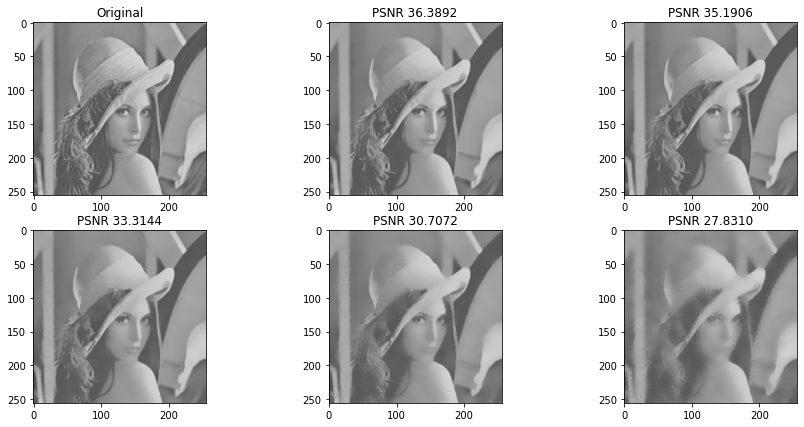

In [ ]:
denoised_naive = []
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = nonlocalmeans_naive(noisy[2], n_big=7, n_small=1, h=2*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_naive.append(denoised)
    oPSNR = PSNR(lena, noisy[i])
    dPSNR = PSNR(lena, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - took {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import BallTree

def nonlocalmeans_clustered(img, n_small=5, n_components=9, n_neighbors=30, h=10):

    Nw = (2 * n_small + 1) ** 2
    h2 = h * h
    n_rows, n_cols = img.shape

    # precompute the coordinate difference for the big patch
    small_rows, small_cols = np.indices(((2 * n_small + 1), (2 * n_small + 1))) - n_small

    # put all patches so we can cluster them
    n_padded = np.pad(img, n_small, mode='reflect')
    patches = np.zeros((n_rows * n_cols, Nw))

    n = 0
    for r in range(n_small, n_small + n_rows):
        for c in range(n_small, n_small + n_cols):
            window = n_padded[r + small_rows, c + small_cols].flatten()
            patches[n, :] = window
            n += 1

    transformed = PCA(n_components=n_components).fit_transform(patches)

    # index the patches into a tree
    tree = BallTree(transformed, leaf_size=2)

    new_img = np.zeros_like(img)
    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            
            trans = transformed[idx].reshape(1, -1)
           
            _, ind = tree.query(trans, k=n_neighbors)
            ridx = np.array([(int(i / n_cols), int(i % n_cols)) for i in ind[0, 1:]])
            colors = img[ridx[:, 0], ridx[:, 1]]
            # compute real patch distances
            dist = [np.mean((patches[i] - patches[idx])**2) for i in ind[0, 1:]]
            w = np.exp(-np.array(dist) / h2)
            new_img[r, c] = np.sum(w * colors) / np.sum(w)

    return new_img

PSNR before 39.9975 - PSNR after denoising 39.6729 - tool 63.9 secs
PSNR before 35.0055 - PSNR after denoising 37.0757 - tool 69.1 secs
PSNR before 29.9862 - PSNR after denoising 32.7065 - tool 82.5 secs
PSNR before 25.0292 - PSNR after denoising 27.6410 - tool 86.3 secs
PSNR before 20.0414 - PSNR after denoising 22.3634 - tool 103.1 secs


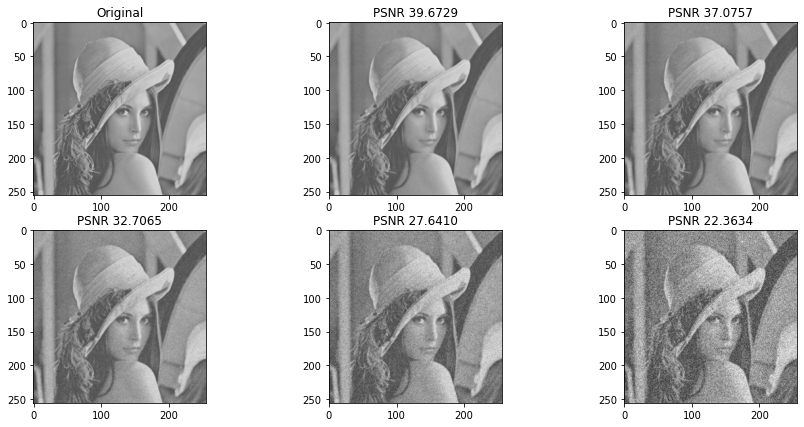

In [ ]:
denoised_clustered = []
plt.figure(figsize=(15,7))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(lena, vmin=0, vmax=100, cmap='gray')
for i,n in enumerate(noisy):
    start = time.time()
    denoised = nonlocalmeans_clustered(n, n_neighbors=30, n_small=1, h=2*sigmas[i])
    end = time.time()
    secs = end-start
    denoised_clustered.append(denoised)
    oPSNR = PSNR(lena, noisy[i])
    dPSNR = PSNR(lena, denoised)
    print("PSNR before {0:.4f} - PSNR after denoising {1:.4f} - tool {2:.1f} secs".format(oPSNR, dPSNR, secs))
    plt.subplot(2,3,i+2)
    plt.title("PSNR {0:.4f}".format(dPSNR))
    plt.imshow(denoised, vmin=0, vmax=100, cmap='gray')

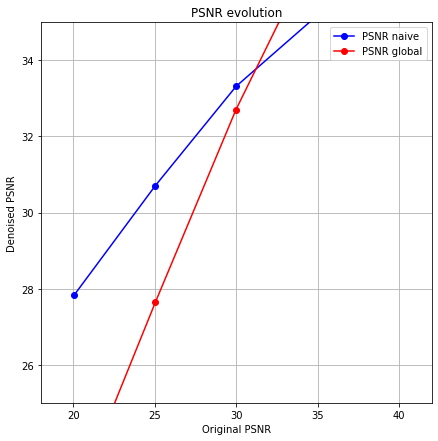

In [ ]:
psnr_noisy = []
psnr_denoised_naive = []
psnr_denoised_clustered = []
for i, n in enumerate(noisy):
    psnr_noisy.append(PSNR(lena, n))
    psnr_denoised_naive.append(PSNR(lena,denoised_naive[i]))
    psnr_denoised_clustered.append(PSNR(lena,denoised_clustered[i]))
plt.figure(figsize=(7,7))
plt.grid(True)
plt.title("PSNR evolution")
plt.xlabel("Original PSNR")
plt.ylabel("Denoised PSNR")
plt.axis([18, 42, 25, 35])
plt.plot(psnr_noisy, psnr_denoised_naive, 'b-o', label="PSNR naive")
plt.plot(psnr_noisy, psnr_denoised_clustered, 'r-o', label="PSNR global")
l = plt.legend()